In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs #módulo de sistemas de coordenadas
import cartopy.feature as cfeature #adicionar continente e oceano nos mapas
import rasterio 
from rasterio.plot import show 
from pyproj import Geod 
from geopy.distance import geodesic 
import geopandas as gpd

In [3]:
#importar os dados .txt
dados = np.loadtxt('data-06-10/dados_tratados3.txt')

#coluna por coluna
dist = dados[:,0] #km
lon = dados [:,1] #o
lat = dados [:,2] #o
batimetria = dados [:,3] #m 
grav = dados [:,4] #mGal
#mag = dados [:,5] #nT

Plotar o mapa e salvar a figura

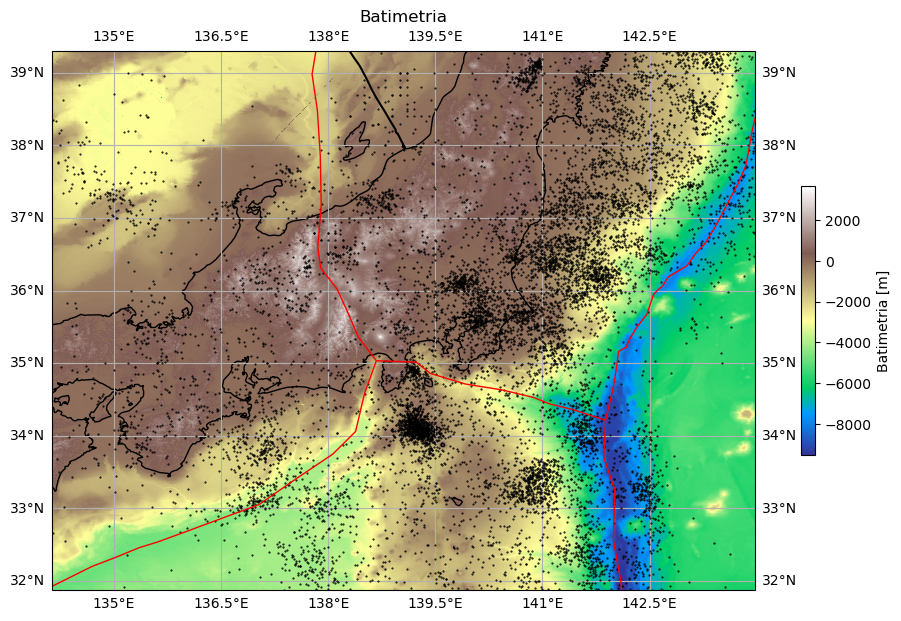

In [4]:

# Ler pontos de sismos (ok)
lat_sismos, lon_sismos = np.loadtxt('data-22-09/loc_sismos.txt', usecols=(0,1), unpack=True)

# Abrir GeoTIFF
with rasterio.open(r'data-22-09/batimetria.tiff') as src:
    img = src.read(1)
    bounds = src.bounds  # limites no CRS do raster
    tr = src.transform
    # Extensão no CRS do raster
    extent_native = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # Levar os bounds para WGS84 (lon/lat)
    if src.crs is not None and not src.crs.is_geographic:
        lon_min, lat_min, lon_max, lat_max = transform_bounds(
            src.crs, "EPSG:4326",
            bounds.left, bounds.bottom, bounds.right, bounds.top,
            densify_pts=21
        )
    else:
        lon_min, lon_max = bounds.left, bounds.right
        lat_min, lat_max = bounds.bottom, bounds.top

# Se o raster é “north-up”, a componente de altura de pixel (tr.e) costuma ser negativa.
# Para usar origin='lower' no imshow, inverta verticalmente:
img_plot = np.flipud(img)  # agora podemos usar origin='lower' com extent em WGS84

# Plot
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use exatamente a mesma extensão do raster em WGS84
extent_wgs84 = [lon_min, lon_max, lat_min, lat_max]

# NÃO subtrair 8 graus; mantenha 1:1 com o raster
ax.set_extent(extent_wgs84, crs=ccrs.PlateCarree())

mapinha = plt.imshow(
    img_plot,
    origin='lower',                      # alinha com o NetCDF (que usamos origin='lower')
    extent=extent_wgs84,                 # casa com o raster
    transform=ccrs.PlateCarree(),
    cmap='terrain',
    interpolation='nearest'
)

ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(mapinha, shrink=0.5)
cbar.set_label('Batimetria [m]')

plt.title('Batimetria')

# Pontos
plt.plot(lon_sismos, lat_sismos, 'ko', markersize=0.5, transform=ccrs.PlateCarree())

# Limites tectônicos
placas = gpd.read_file(r'data-22-09/PB2002_boundaries.shp')
placas.plot(ax=ax, color='red', linewidth=1, transform=ccrs.PlateCarree())
ax.plot(lon,lat,'k')

plt.savefig('gebco.png', dpi=300)
plt.show()


Ver os limites geográficos 

In [5]:
print(f"CRS: {src.crs}")
print(f"extent (imagem): {extent_native}")
print(f"lon_min={lon_min:.6f}, lon_max={lon_max:.6f}")
print(f"lat_min={lat_min:.6f}, lat_max={lat_max:.6f}")

CRS: EPSG:4326
extent (imagem): [134.13333, 143.975, 31.874998742591025, 39.30000125740897]
lon_min=134.133330, lon_max=143.975000
lat_min=31.874999, lat_max=39.300001


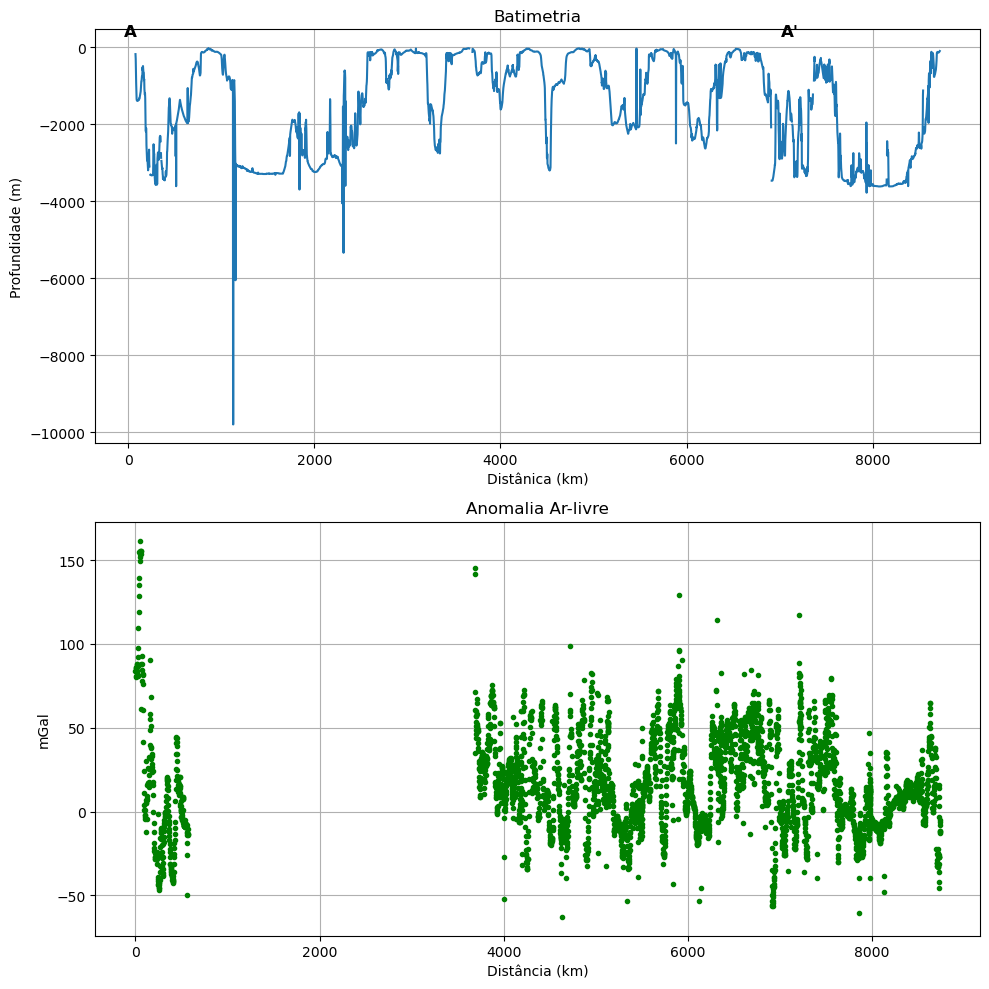

In [6]:
plt.figure(figsize=(10,10))

#subplots - 1 (batimetria)
plt.subplot(2,1,1)
plt.plot(dist,batimetria)
plt.text(-50, 300, "A", fontsize=12, fontweight='bold')
plt.text(7010, 300, "A'", fontsize=12, fontweight='bold')
plt.title('Batimetria')
plt.xlabel('Distânica (km)')
plt.ylabel('Profundidade (m)')
#plt.xlim(3000,3600)
plt.grid(True)
plt.tight_layout() #ajustar os plots para não sobrepor

plt.subplot(2,1,2)
plt.plot(dist,grav, '.g')
plt.title('Anomalia Ar-livre')
plt.xlabel('Distância (km)')
plt.ylabel('mGal')
#plt.xlim(3000,3600)
plt.grid(True)
plt.tight_layout()


Plotar o mapa e salvar xyz

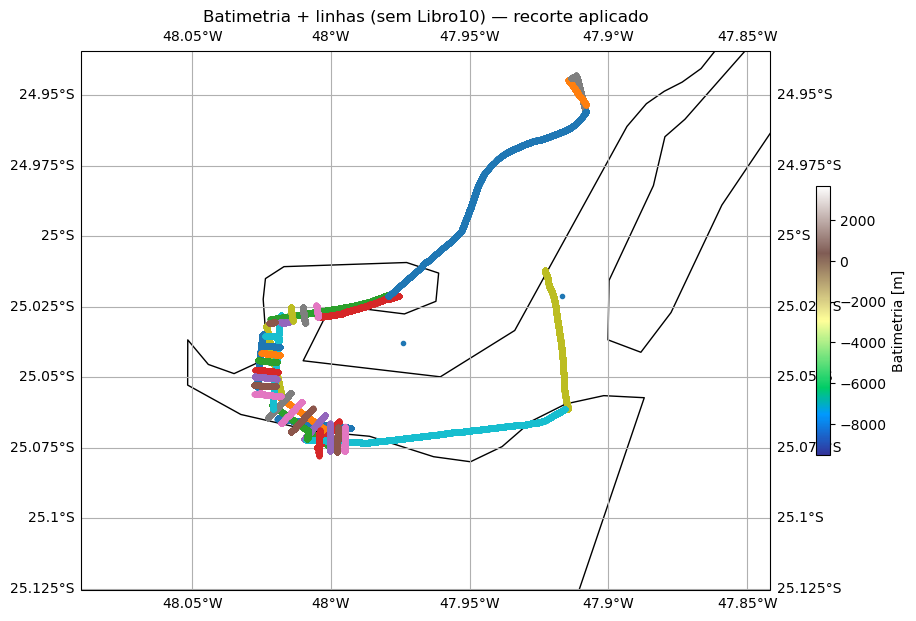

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds
import cartopy.crs as ccrs
import geopandas as gpd
from pyproj import Transformer

# ===================== CONFIGURAÇÕES =====================
# Pasta dos arquivos Libro1..Libro40
pasta_linhas = r"data-06-10"
padrao_nome  = "Libro{}.txt"          # nomes: Libro1.txt, Libro2.txt, ...
pular_indices = {10}                  # >>> PULAR Libro10.txt (10º arquivo)

# Sistema de coordenadas das linhas (UTM zona 23S -> WGS84)
epsg_utm = 32723

# Raster de fundo
caminho_raster = r'data-22-09/batimetria.tiff'

# (opcionais) shapefile e sismos
caminho_shapefile = r"data-22-09/PB2002_boundaries.shp"
caminho_sismos    = r"data-22-09/loc_sismos.txt"  # comente se não tiver

# Área-alvo para recorte final (lon/lat)
lon_min_alvo, lon_max_alvo = -48.0899, -47.8418
lat_min_alvo, lat_max_alvo = -25.1255, -24.9344

# Saída
nome_figura_saida = r"mapa_linhas_sem_Libro10_recorte.png"
# =========================================================

# ---------- leitor robusto: só pares x y e ignora (0,0) ----------
def ler_xy_duas_colunas(caminho, tolerancia_zero=1e-9):
    xs, ys = [], []
    with open(caminho, "r", encoding="utf-8") as f:
        for lin in f:
            cols = lin.strip().split()
            if len(cols) >= 2:
                try:
                    x = float(cols[0]); y = float(cols[1])
                except ValueError:
                    continue
                if abs(x) <= tolerancia_zero and abs(y) <= tolerancia_zero:
                    continue
                xs.append(x); ys.append(y)
    return np.array(xs, float), np.array(ys, float)

# ------------------------- Raster de fundo -------------------------
with rasterio.open(caminho_raster) as src:
    img    = src.read(1)
    bounds = src.bounds
    if src.crs is not None and not src.crs.is_geographic:
        lon_min, lat_min, lon_max, lat_max = transform_bounds(
            src.crs, "EPSG:4326",
            bounds.left, bounds.bottom, bounds.right, bounds.top,
            densify_pts=21
        )
    else:
        lon_min, lon_max = bounds.left, bounds.right
        lat_min, lat_max = bounds.bottom, bounds.top

img_plot     = np.flipud(img)  # para origin='lower'
extent_wgs84 = [lon_min, lon_max, lat_min, lat_max]

# ------------------------- Figura -------------------------
fig = plt.figure(figsize=(12, 7))
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent_wgs84, crs=ccrs.PlateCarree())

mapinha = plt.imshow(
    img_plot,
    origin='lower',
    extent=extent_wgs84,
    transform=ccrs.PlateCarree(),
    cmap='terrain',
    interpolation='nearest'
)

ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)

cbar = plt.colorbar(mapinha, shrink=0.5)
cbar.set_label('Batimetria [m]')

plt.title('Batimetria + linhas (sem Libro10) — recorte aplicado')

# ------------------------- Sismos (opcional) -------------------------
try:
    lat_sismos, lon_sismos = np.loadtxt(caminho_sismos, usecols=(0,1), unpack=True)
    plt.plot(lon_sismos, lat_sismos, 'ko', markersize=0.5, transform=ccrs.PlateCarree())
except Exception:
    pass

# ------------------------- Limites tectônicos (opcional) -------------------------
try:
    placas = gpd.read_file(caminho_shapefile)
    placas.plot(ax=ax, color='red', linewidth=1, transform=ccrs.PlateCarree())
except Exception:
    pass

# ------------------------- Linhas (pula o Libro10) -------------------------
transformador = Transformer.from_crs(epsg_utm, 4326, always_xy=True)

for i in range(1, 41):
    if i in pular_indices:
        continue
    caminho = os.path.join(pasta_linhas, padrao_nome.format(i))
    if not os.path.exists(caminho):
        continue

    x_utm, y_utm = ler_xy_duas_colunas(caminho)
    if x_utm.size < 2:
        print(f"Aviso: {caminho} sem pares x y suficientes.")
        continue

    # UTM -> lon/lat
    lon_lin, lat_lin = transformador.transform(x_utm, y_utm)

    # Plota a linha inteira
    ax.plot(lon_lin, lat_lin, '.', transform=ccrs.PlateCarree(), linewidth=1.2)

# --------- RECORTE FINAL da visualização para a área-alvo ---------
ax.set_extent([lon_min_alvo, lon_max_alvo, lat_min_alvo, lat_max_alvo], crs=ccrs.PlateCarree())

# ------------------------- Salvar / Mostrar -------------------------
plt.savefig(nome_figura_saida, dpi=300)
plt.show()


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer, Geod

# ===================== CONFIGURAÇÕES =====================
# Pasta dos arquivos Libro1..Libro40
pasta_linhas = r"data-06-10"
padrao_nome  = "Libro{}.txt"          # Libro1.txt ... Libro40.txt
pular_indices = {10}                  # pular Libro10

# GeoTIFF de batimetria
caminho_geotiff = r'data-22-09/batimetria.tiff'

# Sistema de coordenadas das linhas (UTM zona 23S -> WGS84)
epsg_utm = 32723

# Saídas (serão salvas na mesma pasta_linhas)
# =========================================================

# ---------- leitor robusto: só pares x y e ignora (0,0) ----------
def ler_xy_duas_colunas(caminho, tolerancia_zero=1e-9):
    xs, ys = [], []
    with open(caminho, "r", encoding="utf-8") as f:
        for lin in f:
            cols = lin.strip().split()
            if len(cols) >= 2:
                try:
                    x = float(cols[0]); y = float(cols[1])
                except ValueError:
                    continue
                if abs(x) <= tolerancia_zero and abs(y) <= tolerancia_zero:
                    continue
                xs.append(x); ys.append(y)
    return np.array(xs, float), np.array(ys, float)

# ---------- abrir raster uma vez ----------
src = rasterio.open(caminho_geotiff)
crs_raster = src.crs
nodata = src.nodata

# ---------- transformadores ----------
transf_utm23s_para_wgs84 = Transformer.from_crs(epsg_utm, 4326, always_xy=True)
transf_wgs84_para_raster = None
if crs_raster is not None and not crs_raster.is_geographic:
    transf_wgs84_para_raster = Transformer.from_crs(4326, crs_raster, always_xy=True)

# ---------- geóide para distância geodésica ----------
geod = Geod(ellps="WGS84")

# ---------- função: amostrar raster nos pontos lon/lat ----------
def amostrar_banda(src, lon, lat):
    """Retorna valores amostrados no raster (na banda 1) nas coords lon/lat."""
    if transf_wgs84_para_raster is not None:
        x, y = transf_wgs84_para_raster.transform(lon, lat)
        coords = list(zip(x, y))
    else:
        coords = list(zip(lon, lat))  # raster já em lon/lat
    amostras = np.array([v[0] for v in src.sample(coords)], dtype=float)
    # remove NoData explícito
    if nodata is not None:
        amostras[np.isclose(amostras, nodata, equal_nan=True)] = np.nan
    return amostras

# ---------- função: distância acumulada (km) ao longo do perfil ----------
def distancia_acumulada_km(lon, lat):
    if lon.size < 2:
        return np.zeros_like(lon, dtype=float)
    # distâncias segmento a segmento em metros
    dists = []
    for i in range(lon.size - 1):
        _, _, dist_m = geod.inv(lon[i], lat[i], lon[i+1], lat[i+1])
        dists.append(dist_m)
    dists = np.r_[0.0, np.array(dists)]  # prepend 0
    return np.cumsum(dists) / 1000.0

# ===================== LOOP PRINCIPAL =====================
for i in range(1, 41):
    if i in pular_indices:
        continue

    caminho = os.path.join(pasta_linhas, padrao_nome.format(i))
    if not os.path.exists(caminho):
        continue

    # 1) ler UTM x y
    x_utm, y_utm = ler_xy_duas_colunas(caminho)
    if x_utm.size < 2:
        print(f"Aviso: {caminho} sem pares x y suficientes.")
        continue

    # 2) UTM 23S -> lon/lat
    lon, lat = transf_utm23s_para_wgs84.transform(x_utm, y_utm)

    # 3) amostrar batimetria no raster
    valores = amostrar_banda(src, lon, lat)

    # 4) distância acumulada (km)
    dist_km = distancia_acumulada_km(lon, lat)

    # 5) salvar TXT: dist_km lon lat valor
    saida_txt = os.path.join(pasta_linhas, f"Libro{i}_batimetria.txt")
    dados = np.column_stack([dist_km, lon, lat, valores])
    np.savetxt(saida_txt, dados, fmt="%.6f %.6f %.6f %.3f")
    print(f"Salvo: {saida_txt}")

    # 6) plot rápido (e salva PNG)
    plt.figure(figsize=(10, 4))
    plt.plot(dist_km, valores, '-', lw=1.2)
    plt.xlabel("Distância acumulada (km)")
    plt.ylabel("Batimetria (m)")
    plt.title(f"Perfil batimétrico – Libro{i}")
    plt.grid(True, alpha=0.3)
    saida_png = os.path.join(pasta_linhas, f"Libro{i}_batimetria.png")
    plt.savefig(saida_png, dpi=200, bbox_inches="tight")
    plt.close()

# fechar raster
src.close()
print("Concluído.")


Salvo: data-06-10/Libro1_batimetria.txt
Salvo: data-06-10/Libro2_batimetria.txt
Salvo: data-06-10/Libro3_batimetria.txt
Salvo: data-06-10/Libro4_batimetria.txt
Salvo: data-06-10/Libro5_batimetria.txt
Salvo: data-06-10/Libro6_batimetria.txt
Salvo: data-06-10/Libro7_batimetria.txt
Salvo: data-06-10/Libro8_batimetria.txt
Salvo: data-06-10/Libro9_batimetria.txt
Salvo: data-06-10/Libro11_batimetria.txt
Salvo: data-06-10/Libro13_batimetria.txt
Salvo: data-06-10/Libro14_batimetria.txt
Salvo: data-06-10/Libro15_batimetria.txt
Salvo: data-06-10/Libro16_batimetria.txt
Salvo: data-06-10/Libro17_batimetria.txt
Salvo: data-06-10/Libro18_batimetria.txt
Salvo: data-06-10/Libro19_batimetria.txt
Salvo: data-06-10/Libro20_batimetria.txt
Salvo: data-06-10/Libro21_batimetria.txt
Salvo: data-06-10/Libro22_batimetria.txt
Salvo: data-06-10/Libro23_batimetria.txt
Salvo: data-06-10/Libro24_batimetria.txt
Salvo: data-06-10/Libro25_batimetria.txt
Salvo: data-06-10/Libro26_batimetria.txt
Salvo: data-06-10/Libro27

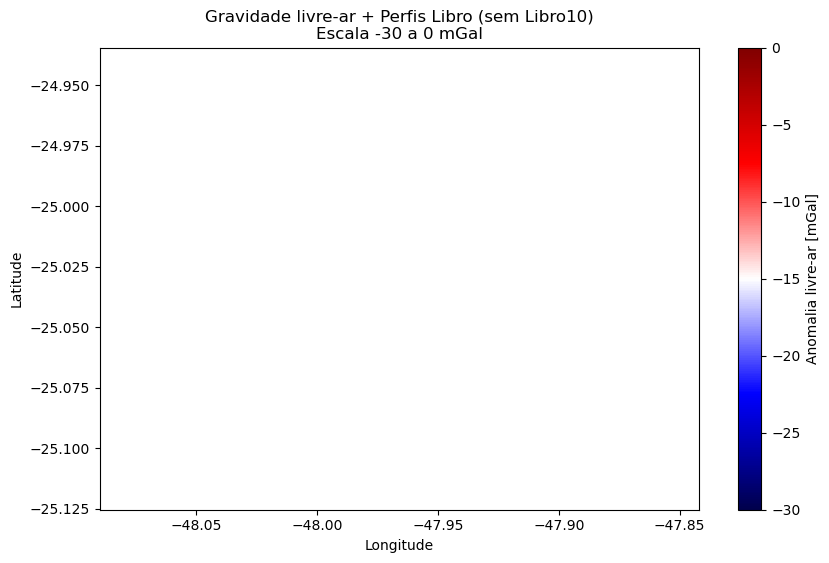

In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from pyproj import Transformer

# ===================== CONFIGURAÇÕES =====================
caminho_tiff = r"data-22-09/batimetria.tiff"
pasta_linhas = r"data-22-09"
padrao_nome  = "Libro{}.txt"   # nomes: Libro1.txt ... Libro40.txt
pular_indices = {10}           # >>> PULAR Libro10.txt

# Sistema dos perfis (UTM zona 23S -> WGS84)
epsg_utm = 32723
transformador = Transformer.from_crs(epsg_utm, 4326, always_xy=True)

# Área-alvo para recorte
lon_min_alvo, lon_max_alvo = -48.0899, -47.8418
lat_min_alvo, lat_max_alvo = -25.1255, -24.9344

# Escala da barra de cores
valor_min, valor_max = -30, 0
# =========================================================

# ---------- Função para ler XY ----------
def ler_xy_duas_colunas(caminho, tolerancia_zero=1e-9):
    xs, ys = [], []
    with open(caminho, "r", encoding="utf-8") as f:
        for lin in f:
            cols = lin.strip().split()
            if len(cols) >= 2:
                try:
                    x = float(cols[0]); y = float(cols[1])
                except ValueError:
                    continue
                # Ignora linhas zeradas
                if abs(x) <= tolerancia_zero and abs(y) <= tolerancia_zero:
                    continue
                xs.append(x); ys.append(y)
    return np.array(xs, float), np.array(ys, float)

# ---------- Abrir TIFF ----------
with rasterio.open(caminho_tiff) as src:
    imagem = src.read(1)
    bounds = src.bounds
    ncols, nrows = src.width, src.height

# Vetores lon/lat
lons = np.linspace(bounds.left, bounds.right, ncols)
lats = np.linspace(bounds.top, bounds.bottom, nrows)

# Corrigir longitude 0–360 -> –180–180
lons = np.where(lons > 180, lons - 360, lons)

# Reordenar longitudes
sort_idx = np.argsort(lons)
lons_sorted = lons[sort_idx]
imagem_sorted = imagem[:, sort_idx]

# ---------- Figura ----------
plt.figure(figsize=(10, 6))
plt.imshow(
    imagem_sorted, cmap="seismic",
    extent=(lons_sorted.min(), lons_sorted.max(), lats.min(), lats.max()),
    origin="upper",
    vmin=valor_min, vmax=valor_max    # <<< escala definida nas variáveis
)
plt.colorbar(label="Anomalia livre-ar [mGal]")
plt.title(f"Gravidade livre-ar + Perfis Libro (sem Libro10)\nEscala {valor_min} a {valor_max} mGal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# ---------- Adicionar perfis ----------
for i in range(1, 41):
    if i in pular_indices:
        continue
    caminho = os.path.join(pasta_linhas, padrao_nome.format(i))
    if not os.path.exists(caminho):
        continue
    x_utm, y_utm = ler_xy_duas_colunas(caminho)
    if x_utm.size < 2:
        continue

    # Converter UTM -> lon/lat
    lon_lin, lat_lin = transformador.transform(x_utm, y_utm)

    # Máscara para a área de interesse
    m = (lon_lin >= lon_min_alvo) & (lon_lin <= lon_max_alvo) & \
        (lat_lin >= lat_min_alvo) & (lat_lin <= lat_max_alvo)

    if np.count_nonzero(m) >= 2:
        plt.plot(lon_lin[m], lat_lin[m], 'k-', linewidth=1.0)

# ---------- Recorte da área ----------
plt.xlim(lon_min_alvo, lon_max_alvo)
plt.ylim(lat_min_alvo, lat_max_alvo)

plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer

# ===================== CONFIG =====================
caminho_tiff  = r"C:\Users\Renata\Documents\AULA IO\Aula 3\grav_fa.tiff"
pasta_linhas  = r"C:\Users\Renata\Documents\AULA IO\Aula 3"
padrao_nome   = "Libro{}.txt"           # Libro1.txt ... Libro40.txt
pular_indices = {10}                    # pule o Libro10; remova do set se quiser incluir

# Perfis em UTM zona 23S -> lon/lat
transformador = Transformer.from_crs(32723, 4326, always_xy=True)

# ============ utilidades ============
def ler_xy_duas_colunas(caminho, tolerancia_zero=1e-9):
    xs, ys = [], []
    with open(caminho, "r", encoding="utf-8") as f:
        for lin in f:
            cols = lin.strip().split()
            if len(cols) >= 2:
                try:
                    x = float(cols[0]); y = float(cols[1])
                except ValueError:
                    continue
                if abs(x) <= tolerancia_zero and abs(y) <= tolerancia_zero:
                    continue
                xs.append(x); ys.append(y)
    return np.array(xs, float), np.array(ys, float)

def wrap_lon_if_needed(lon_deg, bounds_left, bounds_right):
    """
    Se o raster estiver em 0–360 (ex.: bounds ~ 310..313),
    embrulha lon negativas para 0–360.
    """
    if bounds_left >= 0 and bounds_right > 180:
        lon_wrapped = lon_deg % 360.0
        return lon_wrapped
    return lon_deg

# ============ abrir raster e preparar ============
with rasterio.open(caminho_tiff) as src:
    arr     = src.read(1)      # NÃO inverter para amostrar
    bounds  = src.bounds       # usado para decidir 0–360 vs -180..180
    nrows, ncols = arr.shape

    for i in range(1, 41):
        if i in pular_indices:
            continue

        caminho = os.path.join(pasta_linhas, padrao_nome.format(i))
        if not os.path.exists(caminho):
            continue

        # 1) ler perfil em UTM e converter p/ lon/lat
        x_utm, y_utm = ler_xy_duas_colunas(caminho)
        if x_utm.size < 2:
            print(f"Aviso: {caminho} sem pares x y suficientes.")
            continue

        lon, lat = transformador.transform(x_utm, y_utm)

        # 2) wrap de longitude se TIFF estiver em 0–360
        lon_samp = wrap_lon_if_needed(lon, bounds.left, bounds.right)

        # 3) amostrar valores com verificação de limites
        valores = []
        for lo, la in zip(lon_samp, lat):
            try:
                r, c = src.index(lo, la)  # linha, coluna
                if 0 <= r < nrows and 0 <= c < ncols:
                    valores.append(float(arr[r, c]))
                else:
                    valores.append(np.nan)
            except Exception:
                valores.append(np.nan)
        valores = np.array(valores, float)

        # 4) salvar TXT (lon/lat originais em -180..180; só o sampling usou lon_samp)
        saida_txt = os.path.join(pasta_linhas, f"Libro{i}_gravidade.txt")
        with open(saida_txt, "w", encoding="utf-8") as f:
            for lo, la, va in zip(lon, lat, valores):
                f.write(f"{lo:.6f} {la:.6f} {va:.6f}\n")
        print(f"TXT salvo: {saida_txt}")

        # 5) plot simples do perfil (valor vs índice)
        plt.figure(figsize=(9, 3.5))
        plt.plot(valores, "-", lw=1.2)
        plt.title(f"Perfil de Gravidade – Libro{i}")
        plt.xlabel("Ponto ao longo do perfil")
        plt.ylabel("Anomalia livre-ar [mGal]")
        plt.grid(True, alpha=0.3)
        saida_png = os.path.join(pasta_linhas, f"Libro{i}_gravidade.png")
        plt.savefig(saida_png, dpi=180, bbox_inches="tight")
        plt.close()
        print(f"PNG salvo: {saida_png}")

print("Concluído.")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer, Geod

# ===================== CONFIGURAÇÕES =====================
pasta_linhas   = r"C:\Users\Renata\Documents\AULA IO\Aula 3"
padrao_nome    = "Libro{}.txt"        # Libro1.txt ... Libro40.txt
pular_indices  = {10}                 # pular Libro10

# GeoTIFF de gravidade (0–360° em lon)
caminho_geotiff = r"C:\Users\Renata\Documents\AULA IO\Aula 3\grav_fa.tiff"

# Sistema de coordenadas das linhas (UTM zona 23S -> WGS84)
epsg_utm = 32723

# ===== leitor robusto: só pares x y e ignora (0,0) =====
def ler_xy_duas_colunas(caminho, tolerancia_zero=1e-9):
    xs, ys = [], []
    with open(caminho, "r", encoding="utf-8") as f:
        for lin in f:
            cols = lin.strip().split()
            if len(cols) >= 2:
                try:
                    x = float(cols[0]); y = float(cols[1])
                except ValueError:
                    continue
                if abs(x) <= tolerancia_zero and abs(y) <= tolerancia_zero:
                    continue
                xs.append(x); ys.append(y)
    return np.array(xs, float), np.array(ys, float)

# ===== distância acumulada (km) igual à da batimetria =====
geod = Geod(ellps="WGS84")
def distancia_acumulada_km(lon, lat):
    if lon.size < 2:
        return np.zeros_like(lon, dtype=float)
    dists = []
    for i in range(lon.size - 1):
        _, _, dist_m = geod.inv(lon[i], lat[i], lon[i+1], lat[i+1])
        dists.append(dist_m)
    dists = np.r_[0.0, np.array(dists)]
    return np.cumsum(dists) / 1000.0

# ===== wrap de lon para 0–360 SÓ para amostrar o TIFF =====
def wrap_lon_0360(lon_deg):
    lon_wrapped = lon_deg % 360.0
    return lon_wrapped

# ===================== LOOP PRINCIPAL =====================
transf_utm23s_para_wgs84 = Transformer.from_crs(epsg_utm, 4326, always_xy=True)

with rasterio.open(caminho_geotiff) as src:
    arr    = src.read(1)    # usado só para debug rápido por índice, se quiser
    bounds = src.bounds     # decide 0–360 vs -180..180
    nrows, ncols = arr.shape

    # O TIFF do ICGEM está em 0–360 (ex.: 310..313); checagem simples:
    raster_em_0360 = (bounds.left >= 0) and (bounds.right > 180)

    for i in range(1, 41):
        if i in pular_indices:
            continue

        caminho = os.path.join(pasta_linhas, padrao_nome.format(i))
        if not os.path.exists(caminho):
            continue

        # 1) ler UTM x y
        x_utm, y_utm = ler_xy_duas_colunas(caminho)
        if x_utm.size < 2:
            print(f"Aviso: {caminho} sem pares x y suficientes.")
            continue

        # 2) UTM 23S -> lon/lat (em -180..180)
        lon, lat = transf_utm23s_para_wgs84.transform(x_utm, y_utm)

        # 3) distância acumulada (km) — MESMA lógica da batimetria
        dist_km = distancia_acumulada_km(lon, lat)

        # 4) coordenadas para amostrar o raster
        if raster_em_0360:
            lon_para_sample = wrap_lon_0360(lon)   # só para sample
        else:
            lon_para_sample = lon

        # 5) amostrar valores do TIFF nos pontos do perfil
        coords_sample = list(zip(lon_para_sample, lat))
        valores = np.array([v[0] for v in src.sample(coords_sample)], dtype=float)

        # 6) salvar TXT: dist_km lon lat valor (idêntico ao formato da batimetria)
        saida_txt = os.path.join(pasta_linhas, f"Libro{i}_gravidade.txt")
        dados = np.column_stack([dist_km, lon, lat, valores])
        np.savetxt(saida_txt, dados, fmt="%.6f %.6f %.6f %.3f")
        print(f"Salvo: {saida_txt}")

        # 7) plot e salvar PNG: valor × distância (km)
        plt.figure(figsize=(10, 4))
        plt.plot(dist_km, valores, '-', lw=1.2)
        plt.xlabel("Distância acumulada (km)")
        plt.ylabel("Anomalia livre-ar (mGal)")
        plt.title(f"Perfil gravimétrico – Libro{i}")
        plt.grid(True, alpha=0.3)
        saida_png = os.path.join(pasta_linhas, f"Libro{i}_gravidade.png")
        plt.savefig(saida_png, dpi=200, bbox_inches="tight")
        plt.close()

print("Concluído.")
